In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install category_encoders
import category_encoders as ce
!pip install keras
import keras
from keras import layers
!pip install keras-tuner -q
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTENC, RandomOverSampler

2024-03-18 15:17:56.935421: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 15:17:56.936194: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 15:17:56.940919: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 15:17:57.007375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 15:17:58.028358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
seed = 42

df = pd.read_csv("https://minio.lab.sspcloud.fr/jbrablx/ai_insurance/raw/train.csv")
df.head(10)

df['Vehicle_Damage'] = np.where(df['Vehicle_Damage']!= 'Yes', 1, 0)
df['Gender'] = np.where(df['Gender']!= 'Male', 1, 0)
cats = ['< 1 Year', '1-2 Year', '> 2 Years']
df['Vehicle_Age'] = pd.Categorical(df['Vehicle_Age'],ordered=True, categories=cats)

x = df.drop(['Response'], axis=1)
y = df[['Response']]

encoder = ce.OrdinalEncoder(cols=['Vehicle_Age'])
x = encoder.fit_transform(x)
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

scaler=sc()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [3]:
method = "OVER"
if method == "SMOTE":
    print("SMOTE")
    print("--------")
    cat_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Vehicle_Age']
    smote = SMOTENC(random_state=seed, k_neighbors=15, categorical_features=cat_features)
    x_train, y_train = smote.fit_resample(x_train, y_train)

elif method == "OVER":
    print("RandomOverSampler")
    print("--------")
    rs = RandomOverSampler(random_state=seed)
    x_train, y_train = rs.fit_resample(x_train, y_train)

else:
    pass

RandomOverSampler
--------


In [4]:
x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, test_size=0.8, stratify=y_train, random_state=seed)

x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_val, y_val, test_size=0.2, stratify=y_val, random_state=seed)


### Determining the best hyperparameters for the neural network

In [5]:
def call_existing_code(units, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Dense(units=units, activation='relu', input_dim = 11))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["f1_score"],
    )
    return model

def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, dropout=dropout, lr=lr
    )
    return model


build_model(keras_tuner.HyperParameters())

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [6]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="f1_score",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

tuner.search(x_val_train, y_val_train, epochs=10, batch_size = 100, validation_data=(x_val_test, y_val_test))

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

Trial 10 Complete [00h 01m 04s]
f1_score: 0.6666718125343323

Best f1_score So Far: 0.6666718125343323
Total elapsed time: 00h 08m 38s
Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="f1_score", direction="min")

Trial 00 summary
Hyperparameters:
units: 160
dropout: True
lr: 0.0030693555668115362
Score: 0.6666718125343323

Trial 01 summary
Hyperparameters:
units: 416
dropout: True
lr: 0.0061750137872301535
Score: 0.6666718125343323

Trial 02 summary
Hyperparameters:
units: 256
dropout: True
lr: 0.0016255447085378528
Score: 0.6666718125343323

Trial 03 summary
Hyperparameters:
units: 192
dropout: True
lr: 0.00041721832896797245
Score: 0.6666718125343323

Trial 04 summary
Hyperparameters:
units: 352
dropout: False
lr: 0.0025359172395390105
Score: 0.6666718125343323

Trial 05 summary
Hyperparameters:
units: 384
dropout: False
lr: 0.004311196053909165
Score: 0.6666718125343323

Trial 06 summary
Hyperparameters:
units: 256
dropout: False
lr: 0.003731772479

### Cross-Validation

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 160)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.6673 - loss: 0.4444
Epoch 2/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6665 - loss: 0.4318
Epoch 3/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6674 - loss: 0.4295
Epoch 4/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6652 - loss: 0.4313
Epoch 5/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6672 - loss: 0.4281
Epoch 6/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6675 - loss: 0.4289
Epoch 7/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6665 - loss: 0.4291
Epoch 8/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6670 - loss: 0.4283
Epoch 9/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6668 - loss: 0.4296
Epoch 10/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6671 - loss: 0.4287
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - f1_score: 0.6651 - loss: 0.4275


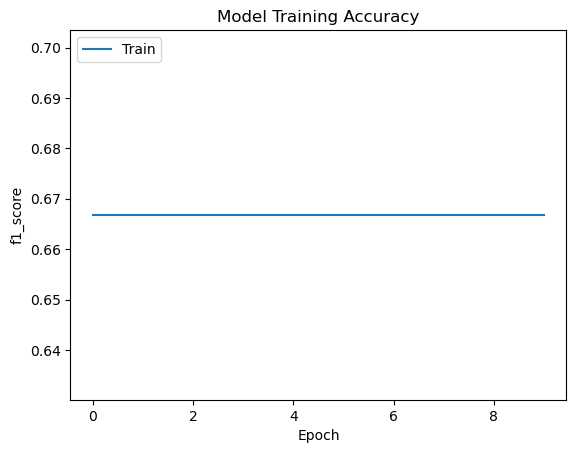

Epoch 1/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6665 - loss: 0.4300
Epoch 2/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6668 - loss: 0.4290
Epoch 3/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6675 - loss: 0.4295
Epoch 4/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.6659 - loss: 0.4299
Epoch 5/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6674 - loss: 0.4285
Epoch 6/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6656 - loss: 0.4297
Epoch 7/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6675 - loss: 0.4292
Epoch 8/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6658 - loss: 0.4290
Epoch 9/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - f1_score: 0.6657 - loss: 0.4282
Epoch 10/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - f1_score: 0.6664 - loss: 0.4283
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - f1_score: 0.6679 - loss: 0.4225


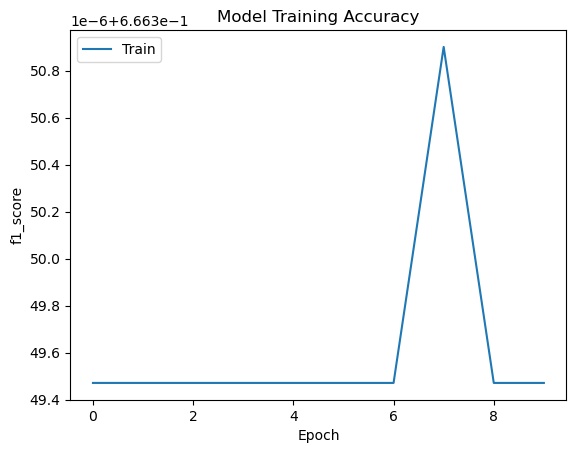

Epoch 1/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6669 - loss: 0.4262
Epoch 2/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6676 - loss: 0.4271
Epoch 3/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6668 - loss: 0.4274
Epoch 4/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6662 - loss: 0.4283
Epoch 5/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.6662 - loss: 0.4278
Epoch 6/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6663 - loss: 0.4277
Epoch 7/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6660 - loss: 0.4258
Epoch 8/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6662 - loss: 0.4257
Epoch 9/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - f1_score: 0.6645 - loss: 0.4276
Epoch 10/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6659 - loss: 0.4273
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - f1_score: 0.6659 - loss: 0.4283


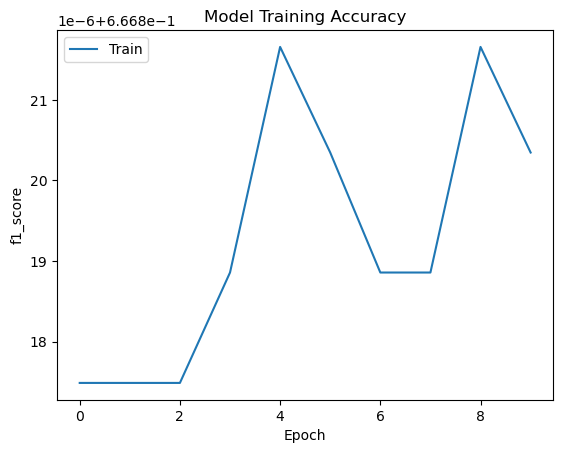

Epoch 1/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6653 - loss: 0.4276
Epoch 2/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6664 - loss: 0.4279
Epoch 3/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6664 - loss: 0.4262
Epoch 4/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6670 - loss: 0.4266
Epoch 5/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.6658 - loss: 0.4272
Epoch 6/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6681 - loss: 0.4268
Epoch 7/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6672 - loss: 0.4267
Epoch 8/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - f1_score: 0.6677 - loss: 0.4279
Epoch 9/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6661 - loss: 0.4273
Epoch 10/10
3211/3211 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.6663 - loss: 0.4264
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - f1_score: 0.6664 - loss: 0.4253


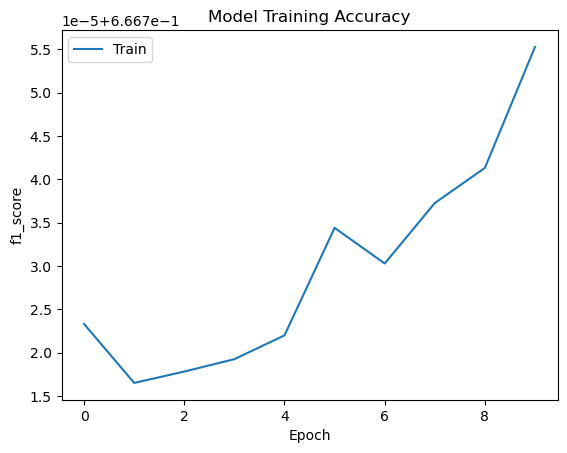

Mean f1_score: 0.667 +/- 0.001


In [8]:
#x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

kfold = KFold(n_splits = 4, shuffle=True, random_state=seed)

# Initialize a list to store the scores
scores = []
 
#model = Sequential() 
#model.add(Dense(128, activation='relu', input_dim=11))
#model.add(Dense(1, activation='sigmoid')) 

# Compile the model
#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['f1_score'])

model.summary()

for train_index, test_index in kfold.split(x_train,y_train):
    # Split the data into train and test sets
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    X_train, X_test = x_train[train_index], x_train[test_index]

    # Fit the model on the training data
    history = model.fit(X_train, Y_train, epochs=10, batch_size=100)

    # Evaluate the model on the test data
    score = model.evaluate(X_test, Y_test)

    # Append the score to the scores list
    scores.append(score[1])
    plt.plot(history.history['f1_score'])
    plt.title('Model Training Accuracy')
    plt.ylabel('f1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
  
# Print the mean and standard deviation of the scores
print(f'Mean f1_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

### Fit

Epoch 1/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - f1_score: 0.6675 - loss: 0.4259 - val_f1_score: 0.2184 - val_loss: 0.4572
Epoch 2/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6672 - loss: 0.4271 - val_f1_score: 0.2184 - val_loss: 0.4571
Epoch 3/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6665 - loss: 0.4270 - val_f1_score: 0.2184 - val_loss: 0.4699
Epoch 4/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6657 - loss: 0.4275 - val_f1_score: 0.2184 - val_loss: 0.4846
Epoch 5/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6657 - loss: 0.4268 - val_f1_score: 0.2184 - val_loss: 0.4838
Epoch 6/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - f1_score: 0.6669 - loss: 0.4263 - val_f1_score: 0.2184 - val_loss: 0.4765
Epoch 7/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6673 - loss: 0.4266 - val_f1_score: 0.2184 - val_loss: 0.4470
Epoch 8/10
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.6666 - loss: 0.

[]

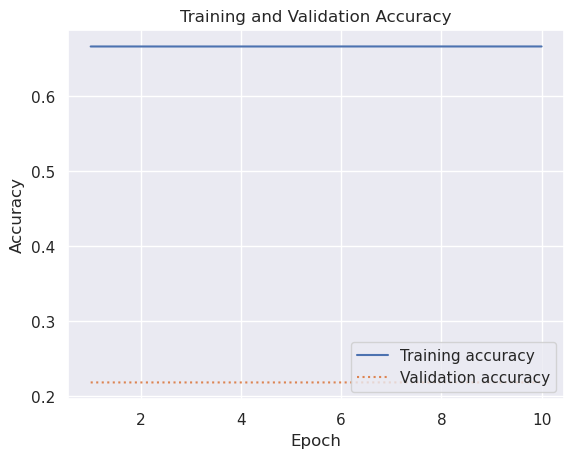

In [9]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

#F1 Score
sns.set()
acc = hist.history['f1_score']
val = hist.history['val_f1_score']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 2s 957us/step


Text(109.44999999999997, 0.5, 'Actual label')

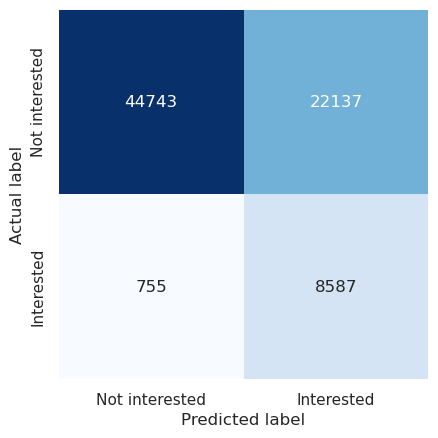

In [10]:
#Confusion Matrix
y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Not interested', 'Interested']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')